# 4 循环神经网络，文本表征，词向量初步，文本自动分类

## TextRNN Model

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
# 文本分类，RNN模型
class TextRNN(nn.Module):   
    def __init__(self):
        super(TextRNN, self).__init__()
        # 进行词嵌入
        self.embedding = nn.Embedding(5000, 64)  
        # self.rnn = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, bidirectional=True)
        self.rnn = nn.GRU(input_size=64, hidden_size=128, num_layers=2, bidirectional=True)
        self.f1 = nn.Sequential(nn.Linear(256,128),
                                nn.Dropout(0.8),
                                nn.ReLU())
        self.f2 = nn.Sequential(nn.Linear(128,10),
                                nn.Softmax())
 
    def forward(self, x):
        x = self.embedding(x)
        x,_ = self.rnn(x)
        x = F.dropout(x,p=0.8)
        x = self.f1(x[:,-1,:])
        return self.f2(x)
 

# cnews loader

In [6]:
import numpy as np
import tensorflow.contrib.keras as kr

In [7]:
# 读取词汇表
def read_vocab(vocab_dir):
    with open(vocab_dir, 'r', encoding='utf-8', errors='ignore') as fp:
        words = [_.strip() for _ in fp.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id

In [8]:
# 读取分类目录，固定
def read_category():
    categories = ['体育', '财经', '房产', '家居', '教育', '科技', '时尚', '时政', '游戏', '娱乐']
    categories = [x for x in categories]
    cat_to_id = dict(zip(categories, range(len(categories)))) 
    return categories, cat_to_id

In [9]:
# 将文件转换为id表示
def process_file(filename, word_to_id, cat_to_id, max_length=600):
    contents, labels = [], []
    with open(filename, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            try:
                label, content = line.strip().split('\t')
                if content:
                    contents.append(list(content))
                    labels.append(label)
            except:
                pass
    data_id, label_id = [], []
    for i in range(len(contents)):
        data_id.append([word_to_id[x] for x in contents[i] if x in word_to_id])#将每句话id化
        label_id.append(cat_to_id[labels[i]])#每句话对应的类别的id
    #
    # # 使用keras提供的pad_sequences来将文本pad为固定长度
    x_pad = kr.preprocessing.sequence.pad_sequences(data_id, max_length)
    y_pad = kr.utils.to_categorical(label_id, num_classes=len(cat_to_id))  # 将标签转换为one-hot表示
    #
    return x_pad, y_pad

In [12]:
# 获取文本的类别及其对应id的字典
categories, cat_to_id = read_category()
print(categories)
# 获取训练文本中所有出现过的字及其所对应的id
words, word_to_id = read_vocab('../resource/cnews/cnews.vocab.txt')
#print(words)
#print(word_to_id)
#print(word_to_id)
#获取字数
vocab_size = len(words)

['体育', '财经', '房产', '家居', '教育', '科技', '时尚', '时政', '游戏', '娱乐']


In [13]:
# 数据加载及分批
# 获取训练数据每个字的id和对应标签的one-hot形式
x_train, y_train = process_file('../resource/cnews/cnews.train.txt', word_to_id, cat_to_id, 600)
print('x_train=', x_train)
x_val, y_val = process_file('../resource/cnews/cnews.val.txt', word_to_id, cat_to_id, 600)

x_train= [[1609  659   56 ...    9  311    3]
 [   2  101   16 ... 1168    3   24]
 [ 465  855  521 ...  116  136   85]
 ...
 [  49   18   79 ...  836 1928 1072]
 [ 166  110  714 ...  836 1928 1072]
 [   1   80  551 ...   78  192    3]]


# 测试

In [14]:
import tensorflow.contrib.keras as kr
import torch
from torch import nn
import numpy as np

In [15]:
vocab_file = '../resource/cnews/cnews.vocab.txt'

In [16]:
class RnnModel:
    def __init__(self):
        self.categories, self.cat_to_id = read_category()
        self.words, self.word_to_id = read_vocab(vocab_file)
        self.model = TextRNN()
        self.model.load_state_dict(torch.load('model_params.pkl'))
 
    def predict(self, message):
        content = message
        data = [self.word_to_id[x] for x in content if x in self.word_to_id]
        data = kr.preprocessing.sequence.pad_sequences([data], 600)
        
        data = torch.LongTensor(data)
        y_pred_cls = self.model(data)
        class_index = torch.argmax(y_pred_cls[0]).item()
        return self.categories[class_index]

In [ ]:
if __name__ == '__main__':
    model = RnnModel()
    test_demo = ['《时光重返四十二难》恶搞唐增取经一款时下最热门的动画人物：猪猪侠，加上创新的故事背景，震撼的操作快感，成就了这部恶搞新作，现正恶搞上市，玩家们抢先赶快体验快感吧。游戏简介：被时光隧道传送到208年的猪猪侠，必须经历六七四十二难的考验，才能借助柯伊诺尔大钻石的力量，开启时光隧道，重返2008年。在迷糊老师、菲菲公主的帮助下，猪猪侠接受了挑战，开始了这段充满了关心和情谊的旅程。    更多精彩震撼感觉，立即下载该款游戏尽情体验吧。玩家交流才是王道，讯易游戏玩家交流中心 QQ群：6306852-----------------生活要有激情，游戏要玩多彩(多彩游戏)。Colourfulgame (多彩游戏)，让你看看快乐游戏的颜色！精品推荐：1：《钟馗传》大战无头关羽，悲壮的剧情伴随各朝英灵反攻地府！2：《中华群英》将和赵云，项羽，岳飞等猛将作战，穿越各朝代抗击日寇。良品推荐：1：《赌王争霸之斗地主》易飞会在四角恋中会选择谁？是否最终成赌神呢？2：勇者后裔和魔王紧缠一起，前代恩怨《圣火伏魔录》将为您揭示一切。  3：颠覆传统概念，恶搞+非主流？！誓必弄死搞残为止《爆笑飞行棋》。4：《中国象棋残局大师》快棋和人机模式让畅快对弈！一切“多彩游戏”资讯，点击Colourfulgame官网http://www.colourfulgame.com一切“多彩游戏”感言，交流Colourfulgame论坛http://121.33.203.124/forum/【客服邮箱】：xunyiwangluo@126.com">xunyiwangluo@126.com">xunyiwangluo@126.com【客服热线】：020-87588437']
                 
    for i in test_demo:
        print(i,":",model.predict(i))

# 将数据集变成小样本

In [20]:
filename = '../resource/cnews/cnews.train.txt'
num_cat = {}
num_max = 100

# 读取文件
contents, labels = [], []
with open(filename, 'r', encoding='utf-8', errors='ignore') as f:
    for line in f:
        label, content = line.strip().split('\t')
        #print(label)
        if content:
            if label not in num_cat:
                num_cat[label] = 1
                contents.append(content)
                labels.append(label)
            else:
                if num_cat[label] < 100:
                    num_cat[label] = num_cat[label] + 1
                    contents.append(content)
                    labels.append(label)

# 写文件
with open('../resource/cnews/cnews.train.small.txt', 'w', encoding='utf-8', errors='ignore') as f:
    for content, label in zip(contents, labels):
        f.write(label + '\t' + content+'\n')
    f.close()
print(len(contents))
print(contents[0])
print(contents[1])
print(num_cat)

1000
马晓旭意外受伤让国奥警惕 无奈大雨格外青睐殷家军记者傅亚雨沈阳报道 来到沈阳，国奥队依然没有摆脱雨水的困扰。7月31日下午6点，国奥队的日常训练再度受到大雨的干扰，无奈之下队员们只慢跑了25分钟就草草收场。31日上午10点，国奥队在奥体中心外场训练的时候，天就是阴沉沉的，气象预报显示当天下午沈阳就有大雨，但幸好队伍上午的训练并没有受到任何干扰。下午6点，当球队抵达训练场时，大雨已经下了几个小时，而且丝毫没有停下来的意思。抱着试一试的态度，球队开始了当天下午的例行训练，25分钟过去了，天气没有任何转好的迹象，为了保护球员们，国奥队决定中止当天的训练，全队立即返回酒店。在雨中训练对足球队来说并不是什么稀罕事，但在奥运会即将开始之前，全队变得“娇贵”了。在沈阳最后一周的训练，国奥队首先要保证现有的球员不再出现意外的伤病情况以免影响正式比赛，因此这一阶段控制训练受伤、控制感冒等疾病的出现被队伍放在了相当重要的位置。而抵达沈阳之后，中后卫冯萧霆就一直没有训练，冯萧霆是7月27日在长春患上了感冒，因此也没有参加29日跟塞尔维亚的热身赛。队伍介绍说，冯萧霆并没有出现发烧症状，但为了安全起见，这两天还是让他静养休息，等感冒彻底好了之后再恢复训练。由于有了冯萧霆这个例子，因此国奥队对雨中训练就显得特别谨慎，主要是担心球员们受凉而引发感冒，造成非战斗减员。而女足队员马晓旭在热身赛中受伤导致无缘奥运的前科，也让在沈阳的国奥队现在格外警惕，“训练中不断嘱咐队员们要注意动作，我们可不能再出这样的事情了。”一位工作人员表示。从长春到沈阳，雨水一路伴随着国奥队，“也邪了，我们走到哪儿雨就下到哪儿，在长春几次训练都被大雨给搅和了，没想到来沈阳又碰到这种事情。”一位国奥球员也对雨水的“青睐”有些不解。
商瑞华首战复仇心切 中国玫瑰要用美国方式攻克瑞典多曼来了，瑞典来了，商瑞华首战求3分的信心也来了。距离首战72小时当口，中国女足彻底从“恐瑞症”当中获得解脱，因为商瑞华已经找到了瑞典人的软肋。找到软肋，保密4月20日奥运会分组抽签结果出来后，中国姑娘就把瑞典锁定为关乎奥运成败的头号劲敌，因为除了浦玮等个别老将之外，现役女足将士竟然没有人尝过击败瑞典的滋味。在中瑞两队共计15次交锋的历史上，中国队6胜3平6负与瑞典队平分秋色，但从2001年起至今近8年时间，中国在同瑞典连续5次交锋中均未尝胜绩

# 使用GRU/LSTM进行文本分类

In [29]:
import torch
from torch import nn
from torch import optim
import numpy as np
import os
import torch.utils.data as Data #将数据分批次需要用到它

In [30]:

# 设置数据集目录
#train_file = '../resource/cnews/cnews.train.small.txt'
train_file = '../resource/cnews/cnews.train.txt'
test_file = '../resource/cnews/cnews.test.txt'
val_file = '../resource/cnews/cnews.val.txt'
vocab_file = '../resource/cnews/cnews.vocab.txt'

In [31]:
def train():
    # 使用LSTM或者CNN
    model = TextRNN().cuda()
    # 选择损失函数
    Loss = nn.MultiLabelSoftMarginLoss()
    #Loss = nn.CrossEntropyLoss()
    #Loss = nn.MSELoss() # 多分类一般不用MSE
    optimizer = optim.Adam(model.parameters(),lr=0.001)
    #optimizer = optim.Adam(model.parameters(),lr=5e-4)
    best_val_acc = 0
    
    # 加载之前训练过的网络参数
    if os.path.exists('model_params.pkl'):
        model.load_state_dict(torch.load('model_params.pkl'))
        
    for epoch in range(1000):
        print('epoch=', epoch)
        # 将训练集分批batch
        for step, (x_batch, y_batch) in enumerate(train_loader):
            x = x_batch.cuda()
            y = y_batch.cuda()
            #print('x=', x)
            out = model(x)
            #print('out=', out)
            #print('y', y)
            loss = Loss(out,y)
            print('loss=', loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            accuracy = np.mean((torch.argmax(out, 1) == torch.argmax(y, 1)).cpu().numpy())
            print(accuracy)
        #对模型进行验证
        if (epoch+1)%5 == 0:
            for step, (x_batch, y_batch) in enumerate(val_loader):
                x = x_batch.cuda()
                y = y_batch.cuda()
                # 前向传播
                out = model(x)
                accuracy = np.mean((torch.argmax(out, 1) == torch.argmax(y, 1)).cpu().numpy())
                if accuracy > best_val_acc:
                    torch.save(model.state_dict(), 'model_params.pkl')
                    best_val_acc = accuracy
                    print('model_params.pkl saved')
                print(accuracy)

In [32]:

# 获取文本的类别及其对应id的字典
categories, cat_to_id = read_category()
#print(categories)
#print(cat_to_id)
# 获取训练文本中所有出现过的字及其所对应的id
words, word_to_id = read_vocab(vocab_file)
#print(words)
#print(word_to_id)
#获取字数
vocab_size = len(words)
#print(vocab_size)

In [33]:
# 数据加载及分批
# 获取训练数据每个字的id和对应标签的one-hot形式
x_train, y_train = process_file(train_file, word_to_id, cat_to_id, 600)
print('x_train=', x_train)
x_val, y_val = process_file(val_file, word_to_id, cat_to_id, 600)

x_train= [[1609  659   56 ...    9  311    3]
 [   2  101   16 ... 1168    3   24]
 [ 465  855  521 ...  116  136   85]
 ...
 [  49   18   79 ...  836 1928 1072]
 [ 166  110  714 ...  836 1928 1072]
 [   1   80  551 ...   78  192    3]]


In [ ]:
# 设置使用GPU
cuda = torch.device('cuda')
x_train, y_train = torch.LongTensor(x_train), torch.Tensor(y_train)
x_val, y_val = torch.LongTensor(x_val), torch.Tensor(y_val)
print(x_train)

train_dataset = Data.TensorDataset(x_train, y_train)
train_loader = Data.DataLoader(
    dataset=train_dataset,# torch TensorDataset format
    batch_size=1000,      # 最新批数据
    shuffle=True,         # 是否随机打乱数据
    num_workers=2,        # 用于加载数据的子进程
)

val_dataset = Data.TensorDataset(x_val, y_val)
val_loader = Data.DataLoader(
    dataset=val_dataset,  # torch TensorDataset format
    batch_size=1000,      # 最新批数据
    shuffle=True,         # 是否随机打乱数据
    num_workers=2,        # 用于加载数据的子进程
)

In [ ]:
train()

In [1]:
## Mnist

In [2]:
import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline

In [3]:
# 超参数定义
EPOCH = 1
BATCH_SIZE = 64
TIME_STEP = 28
INPUT_SIZE = 28
LR = 0.001

9913344it [00:01, 5846159.03it/s]                             


Extracting ../resource/MNIST/raw/train-images-idx3-ubyte.gz to ../resource/MNIST/raw



29696it [00:00, 622530.58it/s]           


Extracting ../resource/MNIST/raw/train-labels-idx1-ubyte.gz to ../resource/MNIST/raw



1649664it [00:00, 4205751.07it/s]                            


Extracting ../resource/MNIST/raw/t10k-images-idx3-ubyte.gz to ../resource/MNIST/raw



5120it [00:00, 25234825.48it/s]         


Extracting ../resource/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../resource/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([60000])


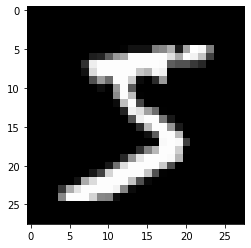

In [4]:
# MNIST数据集下载
train_data = datasets.MNIST(root='../resource', train=True, 
                            transform=transforms.ToTensor(),
                            download = True
                           )
test_data = datasets.MNIST(root='../resource', train=False, 
                            transform=transforms.ToTensor(),
                            download = True
                           )

test_x = test_data.test_data.type(torch.FloatTensor)[:2000] / 255.
test_y = test_data.test_labels.numpy()[:2000]

print(train_data.train_data.size())
print(train_data.train_labels.size())
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.show()
#print(train_data)

In [5]:
# 使用Dataloader进行分批
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# 定义网络
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.GRU(input_size=INPUT_SIZE, hidden_size=64, num_layers=1, batch_first=True)
        self.out = nn.Linear(64, 10) #10个分类

    def forward(self, x):
        # 前向传播
        r_out, _ = self.rnn(x)
        # 选择 r_out的最后一个时间步
        out = self.out(r_out[:,-1,:])
        return out


In [ ]:
# 设置使用GPU
cuda = torch.device('cuda')
rnn = RNN()
rnn = rnn.cuda()
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

In [ ]:
# 训练&验证
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):
        b_x = b_x.view(-1, 28, 28)
        # 前向传播
        output = rnn(b_x.cuda())
        # 损失函数
        loss = loss_func(output, b_y.cuda())
        # 后向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 100 == 0:
            test_output = rnn(test_x.cuda())
            pred_y = torch.max(test_output, 1)[1].data.cpu().numpy()
            # 计算准确率
            accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            print ('Epoch: {}, Step: {}, loss: {}, accuracy: {}'.format(epoch, step, loss, accuracy))

# 从测试集选出10个，进行验证
test_x = test_x.cuda()
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.cpu().numpy()
print('预测数字', pred_y)
print('实际数字', test_y[:10])